In [ ]:
!pip install tensorflow==1.15

In [2]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [24]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

#cityscapes colormap으로 바꾸기
def create_cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[2] = [70, 70, 70]
  colormap[3] = [102, 102, 156]
  colormap[4] = [190, 153, 153]
  colormap[5] = [153, 153, 153]
  colormap[6] = [250, 170, 30]
  colormap[7] = [220, 220, 0]
  colormap[8] = [107, 142, 35]
  colormap[9] = [152, 251, 152]
  colormap[10] = [70, 130, 180]
  colormap[11] = [220, 20, 60]
  colormap[12] = [255, 0, 0]
  colormap[13] = [0, 0, 142]
  colormap[14] = [0, 0, 70]
  colormap[15] = [0, 60, 100]
  colormap[16] = [0, 80, 100]
  colormap[17] = [0, 0, 230]
  colormap[18] = [119, 11, 32]
  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_cityscapes_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def save_output(image, seg_map, filename):
  """ 폴더에 output 저장 """
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.savefig('/content/drive/MyDrive/dataset/output_labelname/%s' %filename, bbox_inches='tight', transparent=True)


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')


  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus','car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike','person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'])

#LABEL_NAMES = np.asarray(['bicyclist', 'pedestrain', 'car', 'fence', 'signSymbol', 'tree', 'pavernent', 'road', 'pole', 'building', 'sky'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [15]:
#MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']
MODEL_NAME = 'xception65_cityscapes_trainfine'  # @param ['xception65_cityscapes_trainfine', 'xception71_dpc_cityscapes_trainfine', 'xception71_dpc_cityscapes_trainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
    'xception71_dpc_cityscapes_trainfine':
        'deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz',
    'xception71_dpc_cityscapes_trainval':
        'deeplab_cityscapes_xception71_trainvalfine_2018_09_08.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image3.jpg?raw=true...


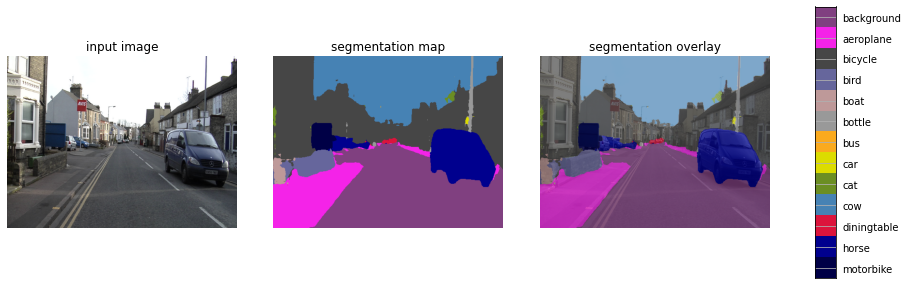

In [25]:
def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    path = '/content/drive/MyDrive/dataset/Original_data/Seq05VD_f05100.png' ##경로 수정!!!!!!!!!!
    with open(path, 'rb') as f:
      data = f.read()
      original_im = Image.open(BytesIO(data))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

반복문 실행
---
이미지 여러장 적용

In [ ]:
def run_visualization():
  """Inferences DeepLab model and visualizes result."""

  try:
    dir = '/content/drive/MyDrive/dataset/Original_data' ##경로 수정!!!!!!!!!!
    for filename in os.listdir(dir):
      path = '/content/drive/MyDrive/dataset/Original_data/%s' %filename ##경로 수정!!!!!!!!!!
      with open(path, 'rb') as f:
        jpeg_str = f.read()
        original_im = Image.open(BytesIO(jpeg_str))

        print('running deeplab on image %s...' %filename)
        resized_im, seg_map = MODEL.run(original_im)

        save_output(resized_im, seg_map, filename)
  
  except IOError:
    print('Cannot retrieve image. Please check url')
    return

run_visualization()